In [ ]:
# This makes a block diagram from information in the FITS headers

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
import pandas as pd
from datetime import datetime
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib inline

In [62]:
gauss_kernel = Gaussian1DKernel(5)

def remove_ramp_return_ramps_image(sciImg):
    '''
    Remove the stray y-illumination from the detector reset, but not the photon-signal pedestal
    it appears to be sitting on. This is especially relevant for UP nods of the Altair dataset.
    '''
    
    # find the median in x across the whole array as a function of y
    stray_ramp = np.nanmedian(sciImg[:,:],axis=1)
    #plt.plot(stray_ramp)
    #plt.show()

    # smooth it
    smoothed_stray_ramp_inc_photons = convolve(stray_ramp, gauss_kernel) # this is 1D
    
    # subtract the (apparent) photon pedestal from the ramp model
    smoothed_stray_ramp_wo_photons = np.subtract(smoothed_stray_ramp_inc_photons,
                                                 np.nanmedian(smoothed_stray_ramp_inc_photons[5:100]))

    #print(np.nanmedian(smoothed_stray_ramp_inc_photons[5:100]))
    
    # subtract from the whole array (note there will still be residual channel pedestals)
    sciImg1 = np.subtract(sciImg,np.tile(smoothed_stray_ramp_wo_photons,(2048,1)).T)

    return [smoothed_stray_ramp_inc_photons,smoothed_stray_ramp_wo_photons,sciImg1]

In [69]:
def simple_mask(sciImg, mask_psf=False):
    '''
    Get rid of regions near PSF or other weird places
    '''
    
    mask_weird = np.ones(np.shape(sciImg))
    mask_weird[0:4,:] = np.nan # lower edge
    mask_weird[-4:,:] = np.nan # upper edge
    mask_weird[:,0:4] = np.nan # left edge
    mask_weird[260:,1046:1258] = np.nan # bullet hole
    mask_weird[:,1500:] = np.nan # unreliable bad pixel mask
    mask_weird[:,:440] = np.nan # unreliable bad pixel mask
    
    if mask_psf:
        mask_weird[:,700:1025] = np.nan # get rid of large area around PSF too
    
    return np.multiply(sciImg,mask_weird)

In [70]:
# stem 

stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/')

/home/../../media/unasemaje/Elements/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/second_attempt/lm_180507_008327.fits
----
264.34941817
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in channel (given total scatter and measured read noise):
nan
expected photon noise in channel (given median photon counts):
nan
----
read noise:
nan
total noise in channel:
nan
calc photon noise in 

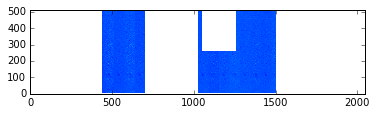

Saved 008327


In [83]:
framenum = 8327
img_string = 'lm_180507_'+str("{:0>6d}".format(framenum))+'.fits'
img_string2 = 'lm_180507_'+str("{:0>6d}".format(framenum+1))+'.fits'
    
print(stem+img_string)
    
# if file exists
if os.path.isfile(stem+img_string):
        
    # read in image
    sciImg, header = fits.getdata(stem+img_string,0,header=True)
    sciImg2, header = fits.getdata(stem+img_string2,0,header=True)
    
    # display
    test = simple_mask(remove_ramp_return_ramps_image(sciImg)[2], mask_psf=True)
    test2 = simple_mask(remove_ramp_return_ramps_image(sciImg2)[2], mask_psf=True)
    
    print('----')
    print(np.nanmedian(test))
    for chNum in range(0,32):
        print('----')
        
        diff_img = np.subtract(test[:,chNum*64:(chNum+1)*64],test2[:,chNum*64:(chNum+1)*64])
        print('read noise:')
        sig_read = np.divide(np.nanstd(diff_img),np.sqrt(2.))
        print(sig_read)
        
        sig_tot = np.nanstd(test[:,chNum*64:(chNum+1)*64])
        sig_phot_calc = np.sqrt(np.power(sig_tot,2.)-np.power(sig_read,2.))
        print('total noise in channel:')
        print(sig_tot)
        print('calc photon noise in channel (given total scatter and measured read noise):')
        print(sig_phot_calc)
        print('expected photon noise in channel (given median photon counts):')
        print(np.sqrt(np.nanmedian(test[:,chNum*64:(chNum+1)*64])))
    
    
    plt.imshow(test, origin="lower")
    plt.show()
           
    # write back out
    #hdu = fits.PrimaryHDU(sciImg1.astype(np.float32), header=header)
    #hdul = fits.HDUList([hdu])
    #hdul.writeto(stem+'../../02_stray_ramp_removed/'+img_string, overwrite=True)
    print('Saved '+str("{:0>6d}".format(framenum)))
        
else:
        
    print('File '+img_string+' not found')

In [5]:
# read in FITS header meta data
full_table = pd.read_csv('fizeau_altair_180507_metadata.csv')

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (13,80,81,84,88,92,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# sort table by frame number (a few are out of order)

full_table.sort_values(["FRAMENUM"], inplace=True)
full_table = full_table.reset_index(drop=True) # reset indices and don't keep the old ones

In [14]:
# print FYI stuff to screen

for t in range(7970,8700):
    print('FRAMENUM: '+str(full_table['FRAMENUM'][t])+
          '| FW1: '+str(full_table['LMIR_FW1'][t])+
          '| FW2: '+str(full_table['LMIR_FW2'][t])+
          '| FW25: '+str(full_table['LMIRFW25'][t])+
          '| FW3: '+str(full_table['LMIR_FW3'][t])+
          '| FW4: '+str(full_table['LMIR_FW4'][t])+
          '| PCCLOSED: '+str(full_table['PCCLOSED'][t])+
         '| ACTEXP: '+str(full_table['ACTEXP'][t]))

FRAMENUM: 7971| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: -99999| ACTEXP: 145976
FRAMENUM: 7972| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: -99999| ACTEXP: 145976
FRAMENUM: 7973| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: -99999| ACTEXP: 145976
FRAMENUM: 7974| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: -99999| ACTEXP: 145976
FRAMENUM: 7975| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: 1| ACTEXP: 145976
FRAMENUM: 7976| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: 1| ACTEXP: 145976
FRAMENUM: 7977| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: 1| ACTEXP: 145976
FRAMENUM: 7978| FW1: 94800| FW2: ND1.0-T10| FW25: Lspec2.8-4.0| FW3: Open| FW4: Br-Alpha-On| PCCLOSED: 1| ACTEXP: 145976
FRAMENUM: 79

In [ ]:
# read in a dark-subtracted FITS file, and
# 1. remove stray voltage effect (to leave only photon-related signal) 
# 2. take a cut-out (to save some memory), 
# 3. put it into a cube

x from 700 to 1040